In [2]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms

import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from CNN import CNN
import similarities 

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



using device: cuda
epoch 99 || avg loss: 0.16 || grad time elapsed: 0.2 s0.0470s/batch)
time elapsed: 1.04 min
(1000,)


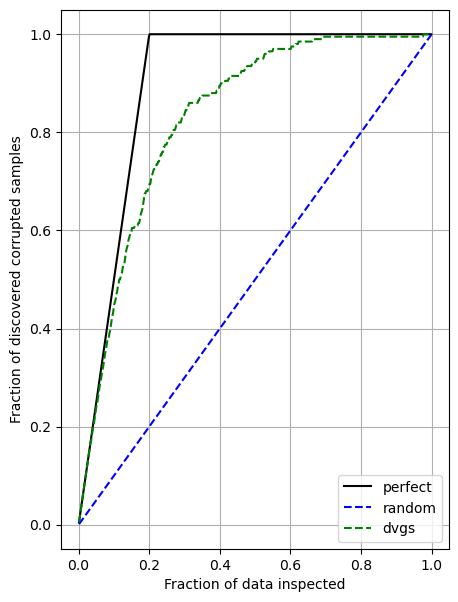

In [38]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

model = NN(in_channels=108, out_channels=1, num_layers=2, hidden_channels=100, norm=True, dropout=0.25, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Sigmoid())
dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)
#dvgs.pretrain_(crit=torch.nn.BCELoss(), num_workers=1, batch_size=256, lr=1e-3, epochs=25)
print()

tic = time.time() 
vals_dvgs, grad_mag = dvgs.run(crit          = torch.nn.BCELoss(), 
                                similarity     = similarities.cosine_similarity(), #similarities.scalar_projection(), #similarities.dot_product(), #similarities.cosine_similarity(), #similarities.C_dist(L=1, unit_norm=True),
                                optim          = torch.optim.Adam, 
                                lr             = 1e-3, 
                                num_epochs     = 100, 
                                compute_every  = 1, 
                                batch_size     = 200, 
                                num_workers    = 1, 
                                grad_params    = None, 
                                verbose        = True, 
                                use_cuda       = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

#pk, p_corr, p_perfect, p_random = get_corruption_scores(np.average(vals_dvgs, axis=1, weights=grad_mag), noise_idx, train_size=1000, noise_prop=0.2)
pk, p_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs.mean(axis=1), noise_idx, train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
#plt.plot(pk, p_corr, 'r--', label='dvgs_weighted')
plt.plot(pk, p_perfect, 'k-', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')
plt.plot(pk, p_corr, 'g--', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [39]:
vals2 = vals_dvgs.mean(axis=1)

In [37]:
vals1 = vals_dvgs.mean(axis=1)

In [40]:
np.corrcoef(vals1, vals2)[0,1]

0.9587170272357793

In [42]:
res = pd.DataFrame({'vals1':vals1, 'vals2':vals2})
res.corr('spearman')

,vals1,vals2
vals1,1.0000,0.9573
vals2,0.9573,1.0000


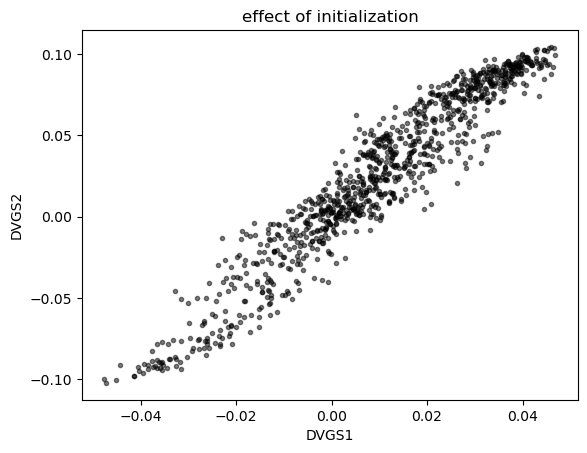

In [46]:
plt.figure()
plt.plot(vals1,vals2, 'k.', alpha=0.5)
plt.xlabel('DVGS1')
plt.ylabel('DVGS2')
plt.title('effect of initialization')
plt.show()

(1000,)
(1000,)
(1000,)


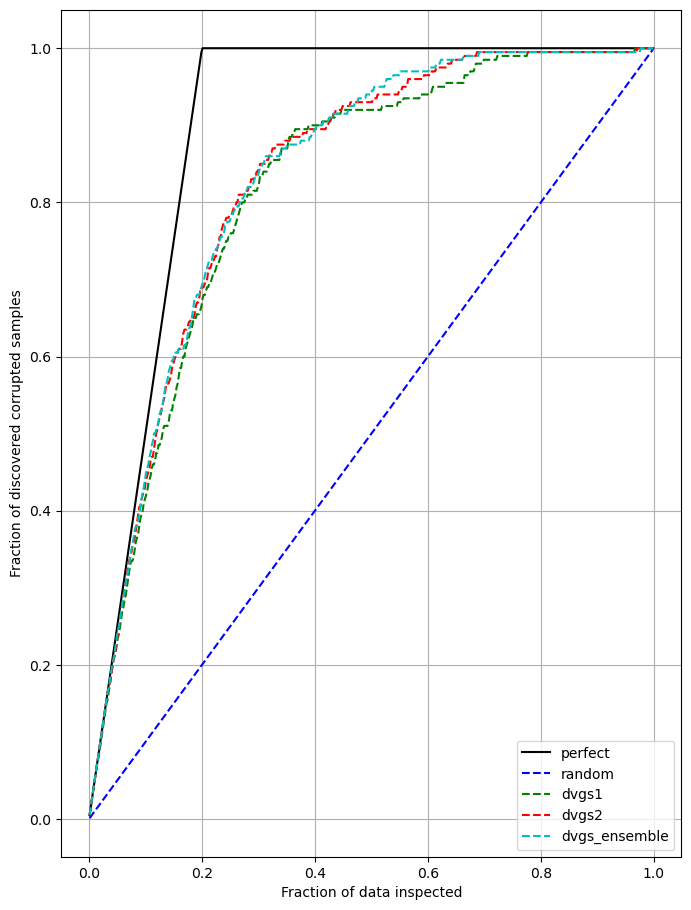

In [53]:
pk, p_corr, p_perfect, p_random = get_corruption_scores(vals1, noise_idx, train_size=1000, noise_prop=0.2)
pk, p_corr2, p_perfect, p_random = get_corruption_scores(vals2, noise_idx, train_size=1000, noise_prop=0.2)
pk, p_corr3, p_perfect, p_random = get_corruption_scores((vals1 + vals2)/2, noise_idx, train_size=1000, noise_prop=0.2)

plt.figure(figsize=(8, 11))
#plt.plot(pk, p_corr, 'r--', label='dvgs_weighted')
plt.plot(pk, p_perfect, 'k-', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')
plt.plot(pk, p_corr, 'g--', label='dvgs1')
plt.plot(pk, p_corr3, 'r--', label='dvgs2')
plt.plot(pk, p_corr2, 'c--', label='dvgs_ensemble')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

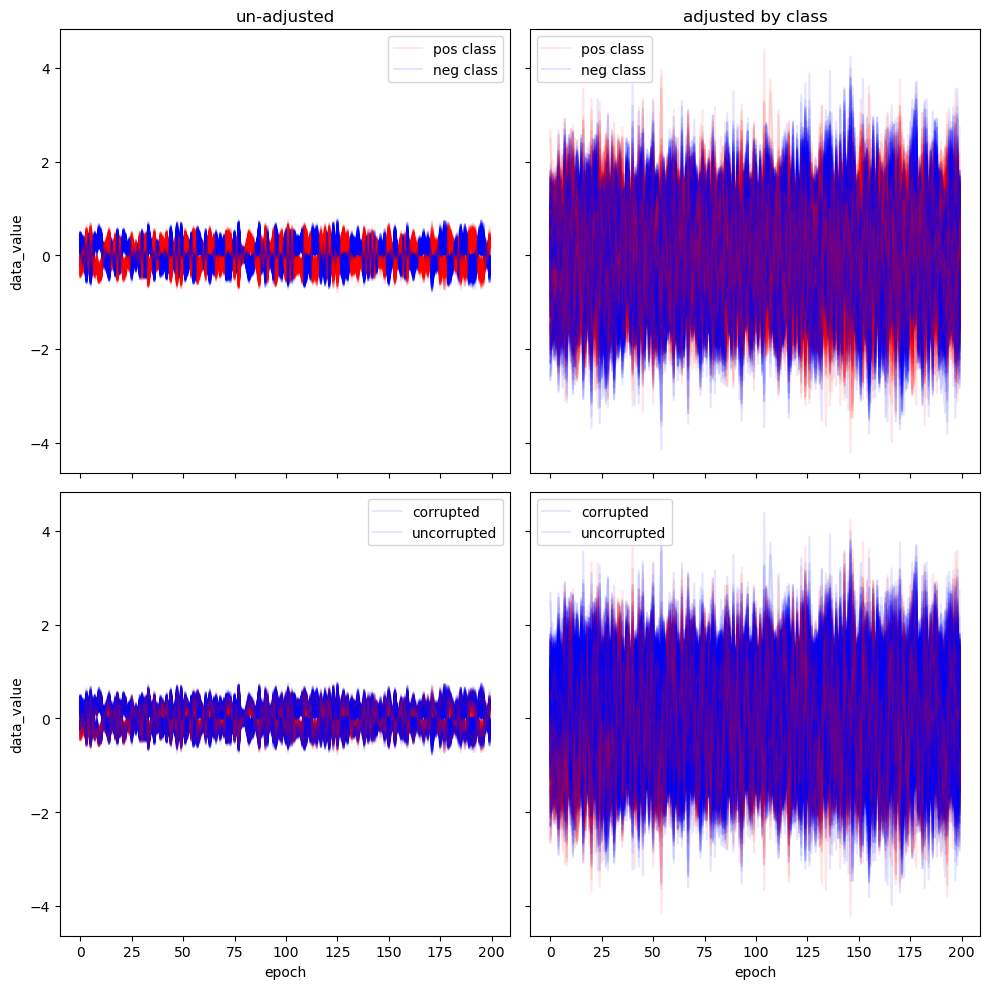

(1000,)


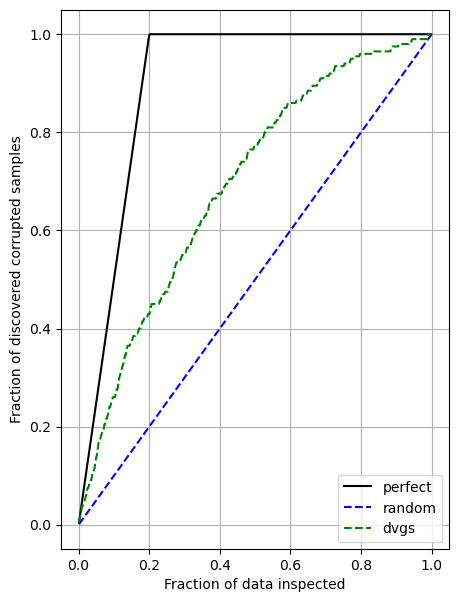

In [36]:
pos_class_idx = y_train.nonzero()[0]
neg_class_idx = np.delete(np.arange(1000), pos_class_idx)
vals_dvgs_adj = vals_dvgs.copy()

#vals_dvgs_adj[pos_class_idx, :] = vals_dvgs[pos_class_idx, :] + grad_mag[pos_class_idx, :].mean(axis=0,keepdims=0)
#vals_dvgs_adj[neg_class_idx, :] = vals_dvgs[neg_class_idx, :]+ grad_mag[neg_class_idx, :].mean(axis=0,keepdims=0)
vals_dvgs_adj[pos_class_idx, :] = vals_dvgs[pos_class_idx, :] - vals_dvgs[pos_class_idx, :].mean(axis=0,keepdims=0)
vals_dvgs_adj[neg_class_idx, :] = vals_dvgs[neg_class_idx, :] - vals_dvgs[neg_class_idx, :].mean(axis=0,keepdims=0)

#vals_dvgs_adj[pos_class_idx, :] = vals_dvgs_adj[pos_class_idx, :] / vals_dvgs_adj[pos_class_idx, :].std(axis=0, keepdims=0)
#vals_dvgs_adj[neg_class_idx, :] = vals_dvgs_adj[neg_class_idx, :] / vals_dvgs_adj[neg_class_idx, :].std(axis=0, keepdims=0)

vals_dvgs_adj = vals_dvgs_adj / vals_dvgs_adj.std(axis=0, keepdims=0)

f,axes = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

for i in range(vals_dvgs.shape[0]):
    if i in pos_class_idx: 
        c = 'r'
    else: 
        c='b'
    axes[0,0].plot(vals_dvgs[i,:], c=c, alpha=0.1)
    axes[0,0].set_ylabel('data_value')
    axes[0,0].legend({'pos class':'r', 'neg class':'b'})
    axes[0,0].set_title('un-adjusted')

for i in range(vals_dvgs.shape[0]):
    if i in noise_idx: 
        c = 'r'
    else: 
        c='b'
    axes[1,0].plot(vals_dvgs[i,:], c=c, alpha=0.1)
    axes[1,0].set_xlabel('epoch')
    axes[1,0].set_ylabel('data_value')
    axes[1,0].legend({'corrupted':'r', 'uncorrupted':'b'})

for i in range(vals_dvgs.shape[0]):
    if i in pos_class_idx: 
        c = 'r'
    else: 
        c='b'
    axes[0,1].plot(vals_dvgs_adj[i,:], c=c, alpha=0.1)
    axes[0,1].legend({'pos class':'r', 'neg class':'b'})
    axes[0,1].set_title('adjusted by class')

for i in range(vals_dvgs.shape[0]):
    if i in noise_idx: 
        c = 'r'
    else: 
        c='b'
    axes[1,1].plot(vals_dvgs_adj[i,:], c=c, alpha=0.1)
    axes[1,1].set_xlabel('epoch')
    axes[1,1].legend({'corrupted':'r', 'uncorrupted':'b'})

plt.tight_layout()
plt.show()

pk, p_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs_adj.mean(axis=1), noise_idx, train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k-', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')
plt.plot(pk, p_corr, 'g--', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

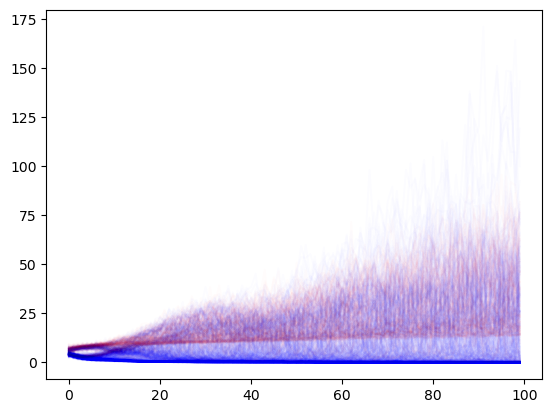

In [18]:
plt.figure()
for i,v in enumerate(grad_mag): 
    if i in noise_idx: 
        plt.plot(v, 'r-', alpha=0.01)
    else: 
        plt.plot(v, 'b', alpha=0.01)
plt.show()

# 


using device: cuda
epoch 99 || avg loss: 0.06 || grad time elapsed: 0.1 s0.0081s/batch)
time elapsed: 0.46 min
(1000,)


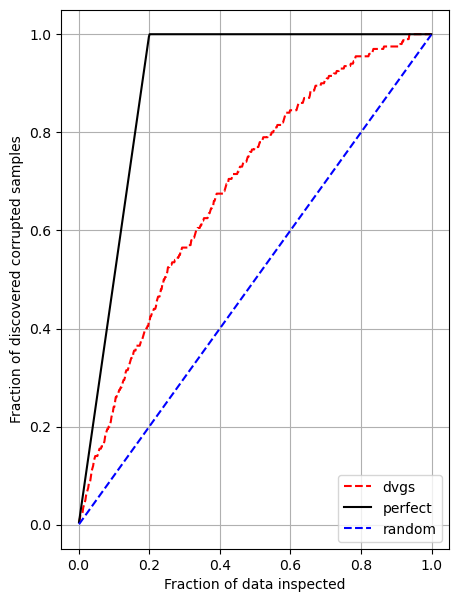

In [21]:
noise_idx = load_tabular_data('blog', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

model = NN(in_channels=280, out_channels=1, num_layers=2, hidden_channels=100, norm=True, dropout=0.25, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Sigmoid())
dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)
#dvgs.pretrain_(crit=torch.nn.BCELoss(), num_workers=1, batch_size=256, lr=1e-3, epochs=25)
print()

tic = time.time() 
vals_dvgs, grad_mag = dvgs.run(crit          = torch.nn.BCELoss(), 
                                similarity     = similarities.cosine_similarity(), 
                                optim          = torch.optim.Adam, 
                                lr             = 1e-3, 
                                num_epochs     = 100, 
                                compute_every  = 1, 
                                batch_size     = 200, 
                                num_workers    = 1, 
                                grad_params    = None, 
                                verbose        = True, 
                                use_cuda       = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

pk, p_corr, p_perfect, p_random = get_corruption_scores(np.average(vals_dvgs, axis=1), noise_idx, train_size=1000, noise_prop=0.2)
#pk2, p_corr2, p_perfect2, p_random2 = get_corruption_scores(np.average(vals_dvgs, axis=1), noise_idx, train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_corr, 'r--', label='dvgs')
plt.plot(pk, p_perfect, 'k-', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

Files already downloaded and verified
Files already downloaded and verified
using device: cuda


/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch: 99 | loss: 1.6521 | metric: 0.8500
using device: cuda


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError

: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()


  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive


    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 

can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():


  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():


  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    

self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>


Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d8c220940>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/teddy/miniconda3/envs/dvgs/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch 99 || avg loss: 1.49 || grad time elapsed: 8.0 s] (0.0505s/batch)
time elapsed: 67.75 min
(50000,)


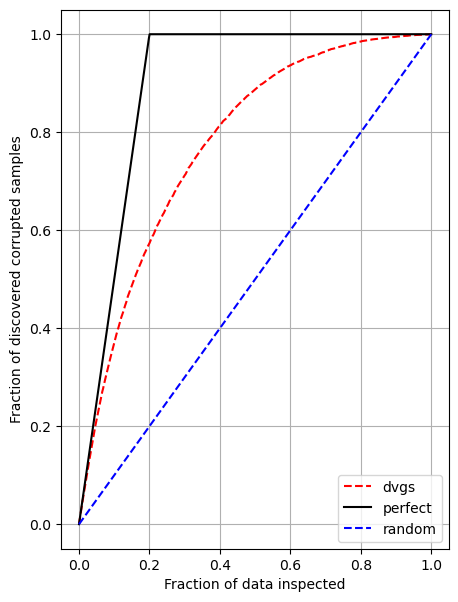

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_dataset.targets, noise_idx = corrupt_label(train_dataset.targets, noise_rate=0.2)

valid_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

model = CNN(in_conv=3, out_conv=24, out_channels=10, kernel_size=5, hidden_channels=200, norm=True, dropout=0.2, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=1))
dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)
dvgs.pretrain_(crit=torch.nn.CrossEntropyLoss(), num_workers=5, batch_size=256, lr=1e-3, epochs=100, use_cuda=True, verbose=True, report_metric=lambda x,y: accuracy_score(x,y.argmax(axis=1)))
#dvgs.model.freeze_conv_layer()
dvgs.model.fc.reset_parameters()
print()

tic = time.time() 
vals_dvgs, grad_mag = dvgs.run(crit          = torch.nn.CrossEntropyLoss(), 
                                similarity     = similarities.cosine_similarity(), 
                                optim          = torch.optim.Adam, 
                                lr             = 1e-3, 
                                num_epochs     = 100, 
                                compute_every  = 1, 
                                batch_size     = 2000, 
                                num_workers    = 1, 
                                grad_params    = ["fc.f.0.weight","fc.f.0.bias","fc.f.3.weight","fc.f.3.bias","fc.f.4.weight","fc.f.4.bias"], 
                                verbose        = True, 
                                use_cuda       = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

pk, p_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs.mean(axis=1), noise_idx, train_size=len(train_dataset), noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_corr, 'r--', label='dvgs')
plt.plot(pk, p_perfect, 'k-', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [84]:
c_true = np.ones_like(train_dataset.targets, dtype=float)
c_true[noise_idx] = 0.
aucs = []
for i in range(vals_dvgs.shape[1]): 
    x = vals_dvgs[:, i]
    z = (x - min(x))/(max(x) - min(x))
    aucs.append( roc_auc_score(c_true, z) )


AttributeError: 'GenDataset' object has no attribute 'targets'

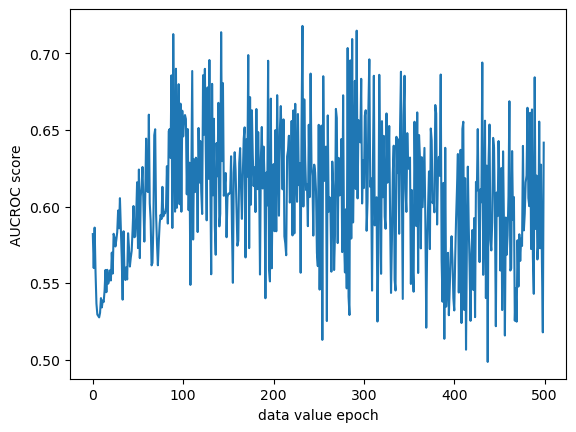

In [ ]:
plt.figure()
plt.plot(aucs)
plt.xlabel('data value epoch')
plt.ylabel('AUCROC score')
plt.show()

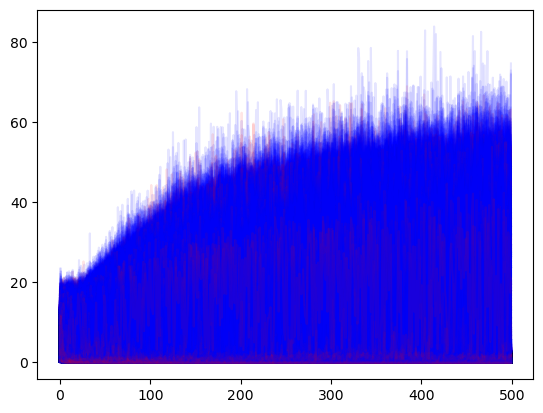

In [30]:
plt.figure()
for i,v in enumerate(grad_mag): 
    if i in noise_idx: 
        plt.plot(v, 'r-', alpha=0.1)
    else: 
        plt.plot(v, 'b', alpha=0.1)
plt.show()

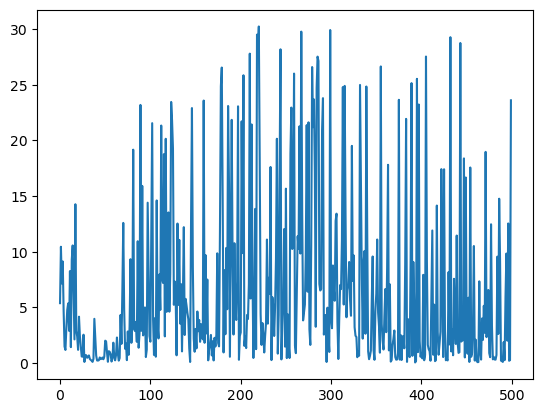

In [26]:
plt.plot(grad_mag[1,:])

In [27]:
res = pd.DataFrame({'val':vals_dvgs.mean(axis=1), 'class':train_dataset.targets})
res = res.merge(res.groupby('class').mean().rename({'val':'class_mean_val'},axis=1).reset_index(), on='class')
res = res.assign(val_adj=lambda x: x.val - x.class_mean_val)
res.head()

,val,class,class_mean_val,val_adj
0,0.006803,6,0.003061,0.003742
1,0.004907,6,0.003061,0.001846
2,0.008775,6,0.003061,0.005714
3,0.006063,6,0.003061,0.003001
4,0.003171,6,0.003061,0.000109


(50000,)


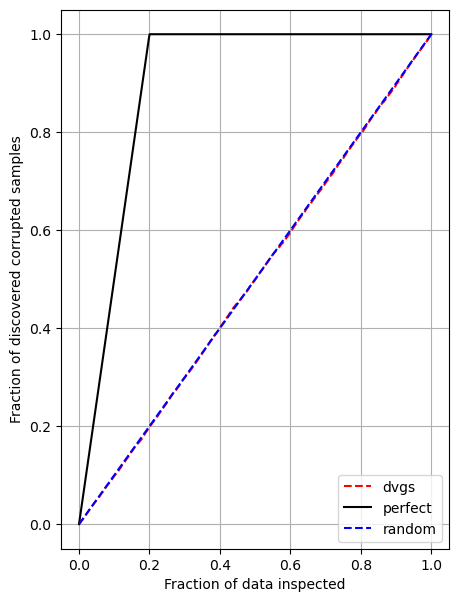

In [28]:
pk, p_corr, p_perfect, p_random = get_corruption_scores(res.val_adj.values, noise_idx, train_size=len(train_dataset), noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_corr, 'r--', label='dvgs')
plt.plot(pk, p_perfect, 'k-', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [29]:
logit = -1.
x1 = torch.tensor([[logit]], requires_grad=True)
x2 = torch.tensor([[logit]], requires_grad=True)

ber = torch.distributions.Bernoulli(logits=x1)
bin = torch.distributions.Binomial(1, logits=x2)

s_ber = ber.sample()
s_bin = bin.sample()

a_bin = bin.log_prob(s_bin)
a_ber = ber.log_prob(s_ber)

dl_bin = torch.autograd.grad(a_bin, x2, create_graph=True)
dl_ber = torch.autograd.grad(a_ber, x1, create_graph=True)

print('s')

s


In [68]:
s_ber = ber.sample()
s_ber

tensor([[0.]])

In [69]:
s_bin = bin.sample()
s_bin

tensor([[0.]])

In [70]:
a_bin = bin.log_prob(s_bin)
a_bin

tensor([[-0.3133]], grad_fn=<SubBackward0>)

In [71]:
a_ber = ber.log_prob(s_ber)
a_ber 

tensor([[-0.3133]], grad_fn=<NegBackward0>)

In [72]:
dl_bin = torch.autograd.grad(a_bin, x2, create_graph=True)
dl_bin

(tensor([[-0.2689]], grad_fn=<AddBackward0>),)

In [73]:
dl_ber = torch.autograd.grad(a_ber, x1, create_graph=True)
dl_ber

(tensor([[-0.2689]], grad_fn=<MulBackward0>),)